In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as st
import pandas as pd
import joypy
import random
from datetime import datetime, timedelta, timezone

from itertools import cycle

from scrape.api import DATETIME_FMT_STR
from scrape.graph import format_dataframe, get_merged_summaries_with_final_actual_intensities
from scrape.summary import get_rows_on_date
from scrape.summary import run as generate_summary
from scrape.graph import generate_plot_ci_lines

In [177]:
# Produce summary data
generate_summary(input_directory="data/national_fw48h", endpoint="national_fw48h", output_directory="data")
generate_summary(input_directory="data/national_pt24h", endpoint="national_pt24h", output_directory="data")

In [4]:
dffw = pd.read_csv("data/summary_national_fw48h.csv", index_col=0, header=[0,1])
dfpt = pd.read_csv("data/summary_national_pt24h.csv", index_col=0, header=[0,1])

# We don't get "actual" intensity from the fw48h endpoint
dffw = dffw.drop("intensity.actual", level=0, axis=1)

In [5]:
merged_df = pd.merge(dffw, dfpt, left_index=True, right_index=True, how="outer")
merged_df = format_dataframe(merged_df)
merged_df

intensity.forecast                              \
time_difference                         47.5   47.0   46.5   46.0   45.5   
2023-03-13 03:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 03:30:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 04:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 04:30:00+00:00                NaN    NaN    NaN    NaN    NaN   
2023-03-13 05:00:00+00:00                NaN    NaN    NaN    NaN    NaN   
...                                      ...    ...    ...    ...    ...   
2023-04-01 11:00:00+00:00              112.0    NaN  112.0    NaN  111.0   
2023-04-01 11:30:00+00:00                NaN  107.0    NaN  107.0    NaN   
2023-04-01 12:00:00+00:00              106.0    NaN  105.0    NaN    NaN   
2023-04-01 12:30:00+00:00                NaN  105.0    NaN    NaN    NaN   
2023-04-01 13:00:00+00:00               99.0    NaN    NaN    NaN    NaN   

                                                         ... intensity.actual  \
time_difference            45.0  44.5  44.0  43.5  43.0  ...            -19.5   
2023-03-13 03:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-03-13 03:30:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-03-13 04:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-03-13 04:30:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-03-13 05:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
...                         ...   ...   ...   ...   ...  ...              ...   
2023-04-01 11:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-04-01 11:30:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-04-01 12:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-04-01 12:30:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   
2023-04-01 13:00:00+00:00   NaN   NaN   NaN   NaN   NaN  ...              NaN   

                                                                           \
time_difference           -20.0 -20.5 -21.0 -21.5 -22.0 -22.5 -23.0 -23.5   
2023-03-13 03:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-13 03:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN  64.0   
2023-03-13 04:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN  56.0  56.0   
2023-03-13 04:30:00+00:00   NaN   NaN   NaN   NaN   NaN  58.0  58.0  58.0   
2023-03-13 05:00:00+00:00   NaN   NaN   NaN   NaN  62.0  62.0  62.0  62.0   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2023-04-01 11:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01 11:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01 12:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01 12:30:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01 13:00:00+00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                 
time_difference           -24.0  
2023-03-13 03:00:00+00:00  64.0  
2023-03-13 03:30:00+00:00  64.0  
2023-03-13 04:00:00+00:00  56.0  
2023-03-13 04:30:00+00:00  58.0  
2023-03-13 05:00:00+00:00  62.0  
...                         ...  
2023-04-01 11:00:00+00:00   NaN  
2023-04-01 11:30:00+00:00   NaN  
2023-04-01 12:00:00+00:00   NaN  
2023-04-01 12:30:00+00:00   NaN  
2023-04-01 13:00:00+00:00   NaN  

[933 rows x 192 columns]

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

plt.figure()
dffw["intensity.forecast"].loc["2023-03-26T18:30Z"].plot()

We will show forecasts from 48 hours before the chosen start date, and also post-hoc "forecasts" and "actual" values taken for 24 hours after that date.

We do this for several hours' worth of data (several time-points) after the chosen start date:

In [ ]:
# Same as the below but on one plot with increasing opacity to indicate more recent values

# Want to show N hours of data. The most recent timepoint for which all data is available will be now - 24 hours.
# The first timepoint will be now - 24 hours - N hours.
hours_of_data = 12
hours_prior_to_now = 24 + hours_of_data
dt_pastpoint = datetime.now(tz=timezone.utc) - timedelta(hours=hours_prior_to_now)

# pick datetimes
nplots = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nplots]

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Don't start from 0 for opacity
alphas = iter(np.linspace(0.1, 1, len(dates)))

colours = cycle(["tab:blue", "tab:orange"])

def ftime(dt):
    return datetime.strftime(dt, "%Y-%m-%d %H:%M")

fig, ax = plt.subplots(1, 1)
for ix, dt in enumerate(dates):
    alpha = next(alphas)
    
    # set label to empty string unless it is the last iteration
    plot_defs = {"ax": ax, "linewidth": 1, "alpha": alpha, "label": ""}
    if dt == dates[-1]:
        plot_defs["label"] = "forecast"
    
    plot_defs["c"] = next(colours)
    fct = merged_df["intensity.forecast"].loc[dt].plot(**plot_defs)
    
    if dt == dates[-1]:
        plot_defs["label"] = "actual"
    plot_defs["c"] = next(colours)
    act = merged_df["intensity.actual"].loc[dt].plot(**plot_defs)
    
    if dt == dates[-1]:
        ax.legend()

        
ax.vlines(0.0,ax.get_ylim()[0],ax.get_ylim()[-1], color='k', linestyle='--', linewidth=0.5)
plt.gca().invert_xaxis()

ax.set_xlabel("hours before forecasted window")
ax.set_ylabel("carbon intensity")

ax.set_title(f"Published CI values, {len(dates)} time windows {ftime(dates[0])} - {ftime(dates[-1])} UTC")

In [ ]:
hours_prior_to_now = 48

dt_now = datetime.now(tz=timezone.utc).strftime(DATETIME_FMT_STR)
dt_pastpoint = datetime.now(tz=timezone.utc) - timedelta(hours=hours_prior_to_now)
hours_of_data = 12

print(f"Date now: {dt_now}\nStart date for analysis: {dt_pastpoint}")

In [ ]:
# Time-points are half-hourly so need twice the rows as hours covered
nrows = hours_of_data * 2
dates = [d for d in merged_df.index if d >= dt_pastpoint][:nrows]
print(f"Will plot {nrows} half-hourly timepoints starting from {hours_prior_to_now} hours ago, {dt_pastpoint}")

# Alternatively plot some random dates
# dates = random.choices(merged_df.index, k=nrows)

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 100

fig, axes = plt.subplots(nrows, 1, sharex=True, sharey="col")
for ix, ax in enumerate(axes):
    merged_df["intensity.forecast"].loc[dates[ix]].plot(ax=ax)
    merged_df["intensity.actual"].loc[dates[ix]].plot(ax=ax)
    ax.text(0.01, 0.95, dates[ix], horizontalalignment='left', verticalalignment='top', transform = ax.transAxes)
    
plt.gca().invert_xaxis()
ymax = plt.gca().get_ylim()[-1]

for ix, ax in enumerate(axes):
    ax.vlines(0.0,0,ymax, color='k', linestyle='--', linewidth=0.5)

Odd in the above that the post-hoc "forecast" value appears to be constant after about 30 minutes after the selected time-point, but the "actual" value continues to change.

The final forecast value doesn't appear until about 30 minutes after the start of the window; same with the "actual" value, which is only available after the end of the given window.

In [ ]:
# Use only forecasts for measuring prediction quality

forecast_df = format_dataframe(dffw)

In [ ]:
# Boxplots for all of the forecasts for a list of given windows

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

print(dates)
ax = forecast_df["intensity.forecast"].loc[dates].T.boxplot(rot=90, sym='r.')
ax.set_title("Carbon intensity forecast ranges for half-hour windows")
ax.set_ylabel("intensity")
ax.grid('on', linestyle='--', alpha=0.33)

In [ ]:
# Get the earliest time from the day a week ago
now = datetime.now(tz=timezone.utc)
dt = now - timedelta(days=7)
dt = datetime(dt.year, dt.month, dt.day, 0, 0, 0).astimezone(timezone.utc)

In [ ]:
# Individual days (about 48 forecasts per day)
x = get_rows_on_date(forecast_df["intensity.forecast"], dt)
x = get_rows_on_date(forecast_df["intensity.forecast"], now)

In [ ]:
# All days from then to now
df_fore = forecast_df.loc[dt:now]["intensity.forecast"].copy()
df_fore.index = df_fore.index.date
df_fore

### Comparison with "actual"

Take a single value as the "actual" intensity for a given window.

In [ ]:
# Get the final (rightmost, assuming we have -24.0 as the rightmost) non-NaN value in each row
merged_df["intensity.actual.final"] = merged_df["intensity.actual"].ffill(axis=1).iloc[:, -1]

# test it works:
merged_df.iloc[640:650]

In [ ]:
dff = merged_df.loc[dt:now][["intensity.forecast", "intensity.actual.final"]].copy()

# Percentage err
dfferr = 100. * (dff["intensity.forecast"].sub(dff["intensity.actual.final"], axis=0)).div(dff["intensity.actual.final"], axis=0)
# only pre-timepoint forecasts
dfferr = dfferr[[c for c in dfferr.columns if float(c) >= 0.0]]

ax = dfferr.boxplot(rot=90)

In [ ]:
ax = dfferr.loc[dates].T.boxplot(rot=90, sym='r.')
ax.set_title("Percentage error from final recorded actual intensity")
ax.set_ylabel("CI forecast % error")
ax.grid('on', linestyle='--', alpha=0.33)

In [ ]:
# All days from then to now
dff = dfferr.loc[dt:now].copy()
dff.index = dff.index.date

# Boxplot summary for a whole day:
# combine all forecasts for that day; don't worry about the number of hours before the window they came from.

forecast_cols = dff.columns

# Add a helper column to count occurrences of each label
dff['count_per_day'] = dff.groupby(dff.index).cumcount()
# pivot into a multiindex
result = dff.pivot_table(index=dff.index, columns='count_per_day', values=list(forecast_cols), aggfunc='first')
# flatten
result.columns = [f'{level1}_{level2+1}' for level1, level2 in result.columns]
# fix, ax = plt.figure("% error on final actual CI value")
ax = result.T.boxplot(sym='r.')
ax.set_title("% error from last 7 days' forecasts")
ax.set_ylabel("% error")
ax.grid('on', linestyle='--', alpha=0.33)

In [ ]:
# Alternative single "actual" values from the mean and median.

merged_df["actual"] = merged_df["intensity.actual"].mean(axis=1)
merged_df["actual_median"] = merged_df["intensity.actual"].median(axis=1)

dfif = merged_df["intensity.forecast"]

df_forecasts_posthoc = dfif[[c for c in dfif.columns if float(c) < 0.0]]
merged_df["actual_forecast"] = df_forecasts_posthoc[-1.0]

In [ ]:
dfsub = merged_df["intensity.forecast"].sub(merged_df["actual"], axis=0)
dfsub_pc = dfsub / merged_df["intensity.forecast"]

dfsub_forecasts = merged_df["intensity.forecast"].sub(merged_df["actual_forecast"], axis=0)
dfsub_fc_pc = dfsub_forecasts / merged_df["intensity.forecast"]

The following Joy / Ridgeline plots are histograms taken across all available data.

For each of the 96 half-hourly timepoints prior to any given target window, we count into a histogram bin if the forecast has this much % error from the final forecast or mean "actual" value (which, confusingly, can change).

In [ ]:
plt.rcParams['figure.figsize'] = [12, 24]
plt.rcParams['figure.dpi'] = 100

# Plot histograms of the actual data differences
# fig, ax = joypy.joyplot(dfsub, linewidth=0.5)
fig, ax = joypy.joyplot(dfsub, hist=True, bins=100, linewidth=0.5)

In [ ]:
# Show a smoothed plot of the relative difference between the forecast and the mean "actual" value after.
fig, axes = joypy.joyplot(dfsub_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

In [ ]:
fig, axes = joypy.joyplot(dfsub_fc_pc, linewidth=0.5)
for ax in axes:
    ax.set_xlim(-1.2, 1.2)

In the above, we show that forecasts are _not great_. A deviation of +/- 1.0 represents a 100% error on the actual value. We can also show the mean and standard deviation percentage errors for each forecasting half-hour.

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [ ]:
means = pd.DataFrame(dfsub_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

In [ ]:
means = pd.DataFrame(dfsub_fc_pc.mean(axis=0)).rename(columns={0: "mean"})
stdevs = pd.DataFrame(dfsub_fc_pc.std(axis=0)).rename(columns={0: "stdev"})
mean_std = pd.concat([means, stdevs], axis=1).reset_index()
mean_std = mean_std.apply(pd.to_numeric, errors='coerce')
ax = plt.errorbar("time_difference", "mean", yerr="stdev", data=mean_std)
plt.ylim(-1., 1.)
plt.xlim(48., -24.)

In [ ]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['figure.dpi'] = 100
ax = (dfsub_pc.mean(axis=0) * 100.).plot(title="Mean percentage error for each forecast")
ax.invert_xaxis()

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()
# ax.vlines("0.0", ax.get_ylim()[0],ax.get_ylim()[1], color='k', linestyle='--', linewidth=0.5)

print(dfsub_pc.std(axis=0) * 100.)

In [179]:
merged_df = get_merged_summaries_with_final_actual_intensities("data")
merged_df = merged_df.drop("intensity.actual", level=0, axis=1)
merged_df

intensity.forecast                                   \
time_difference                         47.5   47.0   46.5   46.0   45.5 45.0   
2023-03-13 03:00:00+00:00                NaN    NaN    NaN    NaN    NaN  NaN   
2023-03-13 03:30:00+00:00                NaN    NaN    NaN    NaN    NaN  NaN   
2023-03-13 04:00:00+00:00                NaN    NaN    NaN    NaN    NaN  NaN   
2023-03-13 04:30:00+00:00                NaN    NaN    NaN    NaN    NaN  NaN   
2023-03-13 05:00:00+00:00                NaN    NaN    NaN    NaN    NaN  NaN   
...                                      ...    ...    ...    ...    ...  ...   
2023-04-01 11:00:00+00:00              112.0    NaN  112.0    NaN  111.0  NaN   
2023-04-01 11:30:00+00:00                NaN  107.0    NaN  107.0    NaN  NaN   
2023-04-01 12:00:00+00:00              106.0    NaN  105.0    NaN    NaN  NaN   
2023-04-01 12:30:00+00:00                NaN  105.0    NaN    NaN    NaN  NaN   
2023-04-01 13:00:00+00:00               99.0    NaN    NaN    NaN    NaN  NaN   

                                               ...                          \
time_difference           44.5 44.0 43.5 43.0  ... -20.0 -20.5 -21.0 -21.5   
2023-03-13 03:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-03-13 03:30:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-03-13 04:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-03-13 04:30:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-03-13 05:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
...                        ...  ...  ...  ...  ...   ...   ...   ...   ...   
2023-04-01 11:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-04-01 11:30:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-04-01 12:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-04-01 12:30:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   
2023-04-01 13:00:00+00:00  NaN  NaN  NaN  NaN  ...   NaN   NaN   NaN   NaN   

                                                        intensity.actual.final  
time_difference           -22.0 -22.5 -23.0 -23.5 -24.0                         
2023-03-13 03:00:00+00:00   NaN   NaN   NaN   NaN  60.0                   64.0  
2023-03-13 03:30:00+00:00   NaN   NaN   NaN  52.0  52.0                   64.0  
2023-03-13 04:00:00+00:00   NaN   NaN  61.0  61.0  61.0                   56.0  
2023-03-13 04:30:00+00:00   NaN  59.0  59.0  59.0  59.0                   58.0  
2023-03-13 05:00:00+00:00  62.0  62.0  62.0  62.0  62.0                   62.0  
...                         ...   ...   ...   ...   ...                    ...  
2023-04-01 11:00:00+00:00   NaN   NaN   NaN   NaN   NaN                    NaN  
2023-04-01 11:30:00+00:00   NaN   NaN   NaN   NaN   NaN                    NaN  
2023-04-01 12:00:00+00:00   NaN   NaN   NaN   NaN   NaN                    NaN  
2023-04-01 12:30:00+00:00   NaN   NaN   NaN   NaN   NaN                    NaN  
2023-04-01 13:00:00+00:00   NaN   NaN   NaN   NaN   NaN                    NaN  

[933 rows x 145 columns]

In [180]:
dff = merged_df

# Percentage error
dfferr = 100.0 * (
    dff["intensity.forecast"].sub(dff["intensity.actual.final"], axis=0)
).div(dff["intensity.actual.final"], axis=0)

# only pre-timepoint forecasts
dfferr = dfferr[[c for c in dfferr.columns if float(c) >= 0.0]]
mean_pc_error = dfferr.mean(axis=0)
standard_error_pc = dfferr.sem(axis=0)

In [181]:
mean_pc_error, standard_error_pc

(time_difference
 47.5   -3.514277
 47.0   -3.223257
 46.5   -2.978206
 46.0   -2.561481
 45.5   -1.962887
           ...   
 2.0     5.057733
 1.5     4.948476
 1.0     4.812661
 0.5     4.455397
 0.0     3.941844
 Length: 96, dtype: float64,
 time_difference
 47.5    1.439665
 47.0    1.452627
 46.5    1.452904
 46.0    1.463955
 45.5    1.468210
           ...   
 2.0     0.877975
 1.5     0.823489
 1.0     0.760282
 0.5     0.685287
 0.0     0.607029
 Length: 96, dtype: float64)

In [182]:
def confidence_95(data):
    # Pandas would remove NaNs for us but not NumPy!
    data = data[~np.isnan(data)]
    m = np.mean(data)
    sem = st.sem(data)
    dof = int(len(data) - 1)
    return st.t.interval(confidence=0.95, df=dof, loc=m, scale=sem)


def confidence_99(data):
    # Pandas would remove NaNs for us but not NumPy!
    data = data[~np.isnan(data)]
    m = np.mean(data)
    sem = st.sem(data)
    dof = int(len(data) - 1)
    return st.t.interval(confidence=0.99, df=dof, loc=m, scale=sem)

stats = dfferr.agg(["count", "mean", "std", "sem", confidence], axis=0)
stats

time_difference,47.5,47.0,46.5,46.0,45.5,45.0,44.5,44.0,43.5,43.0,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
count,469,472,475,478,481,483,485,488,490,493,...,630,632,634,636,638,640,642,644,645,647
mean,-3.514277,-3.223257,-2.978206,-2.561481,-1.962887,-1.278629,-0.57703,-0.076355,0.37879,0.678335,...,6.60945,6.209459,5.857552,5.469191,5.179464,5.057733,4.948476,4.812661,4.455397,3.941844
std,31.177964,31.559133,31.665309,32.006756,32.200357,32.56589,32.895716,33.13039,33.356054,33.457056,...,26.922652,26.291372,25.657314,24.612898,23.511668,22.211194,20.86533,19.293791,17.404133,15.440512
sem,1.439665,1.452627,1.452904,1.463955,1.46821,1.481799,1.493718,1.499742,1.506873,1.50683,...,1.072624,1.045815,1.018982,0.975965,0.930836,0.877975,0.823489,0.760282,0.685287,0.607029
confidence,"(-6.34328411233106, -0.6852701367732745)","(-6.077688725322345, -0.368826241440535)","(-5.833134939879272, -0.12327623241722918)","(-5.438078815472917, 0.3151169795744999)","(-4.847799267752613, 0.9220262278283273)","(-4.190212974016938, 1.6329556450441984)","(-3.5120020127895812, 2.3579416758193266)","(-3.02311901921246, 2.870409632498394)","(-2.5819551347413614, 3.339534281135658)","(-2.2822810833279883, 3.6389502711459922)",...,"(4.503092605103733, 8.715808119907706)","(4.155760328683263, 8.263156720035582)","(3.8565574861192893, 7.858546014481147)","(3.552682152191549, 7.385700050921773)","(3.351586459039555, 7.007341951523014)","(3.3336689085680673, 6.781796881776429)","(3.3314137644152186, 6.56553754482524)","(3.3197257327659973, 6.305596280382915)","(3.1097301447740797, 5.80106410917875)","(2.74985576007196, 5.1338329191534635)"


In [183]:
confidence_level = 0.95
# dof = len(percentage_errors) - 1
# confidence_interval_percentage = st.t.interval(confidence_level, dof, mean_percentage_error, standard_deviation_percentage)
st.t.interval(0.95, 468, -3.514277, 31.177964)

(-64.78040582692671, 57.7518518269267)

In [184]:
-3.514277 + (1.96 * 31.177964 / np.sqrt(468))

-0.6895212843784893

In [185]:
-3.514277 - (1.96 * 31.177964 / np.sqrt(468))

-6.33903271562151

In [186]:
-3.514277 + 1.96 * 1.439665

-0.6925336

In [187]:
-3.514277 - 1.96 * 1.439665

-6.3360204

In [188]:
# ?? st.norm.interval

In [189]:
st.t.interval(confidence=0.95, df=469-1, loc=-3.514277, scale=1.439665)

(-6.343284736285071, -0.6852692637149289)

In [190]:
stats.T

,count,mean,std,sem,confidence
time_difference,,,,,
47.5,469,-3.514277,31.177964,1.439665,"(-6.34328411233106, -0.6852701367732745)"
47.0,472,-3.223257,31.559133,1.452627,"(-6.077688725322345, -0.368826241440535)"
46.5,475,-2.978206,31.665309,1.452904,"(-5.833134939879272, -0.12327623241722918)"
46.0,478,-2.561481,32.006756,1.463955,"(-5.438078815472917, 0.3151169795744999)"
45.5,481,-1.962887,32.200357,1.46821,"(-4.847799267752613, 0.9220262278283273)"
...,...,...,...,...,...
2.0,640,5.057733,22.211194,0.877975,"(3.3336689085680673, 6.781796881776429)"
1.5,642,4.948476,20.86533,0.823489,"(3.3314137644152186, 6.56553754482524)"
1.0,644,4.812661,19.293791,0.760282,"(3.3197257327659973, 6.305596280382915)"


<Axes: xlabel='time_difference'>

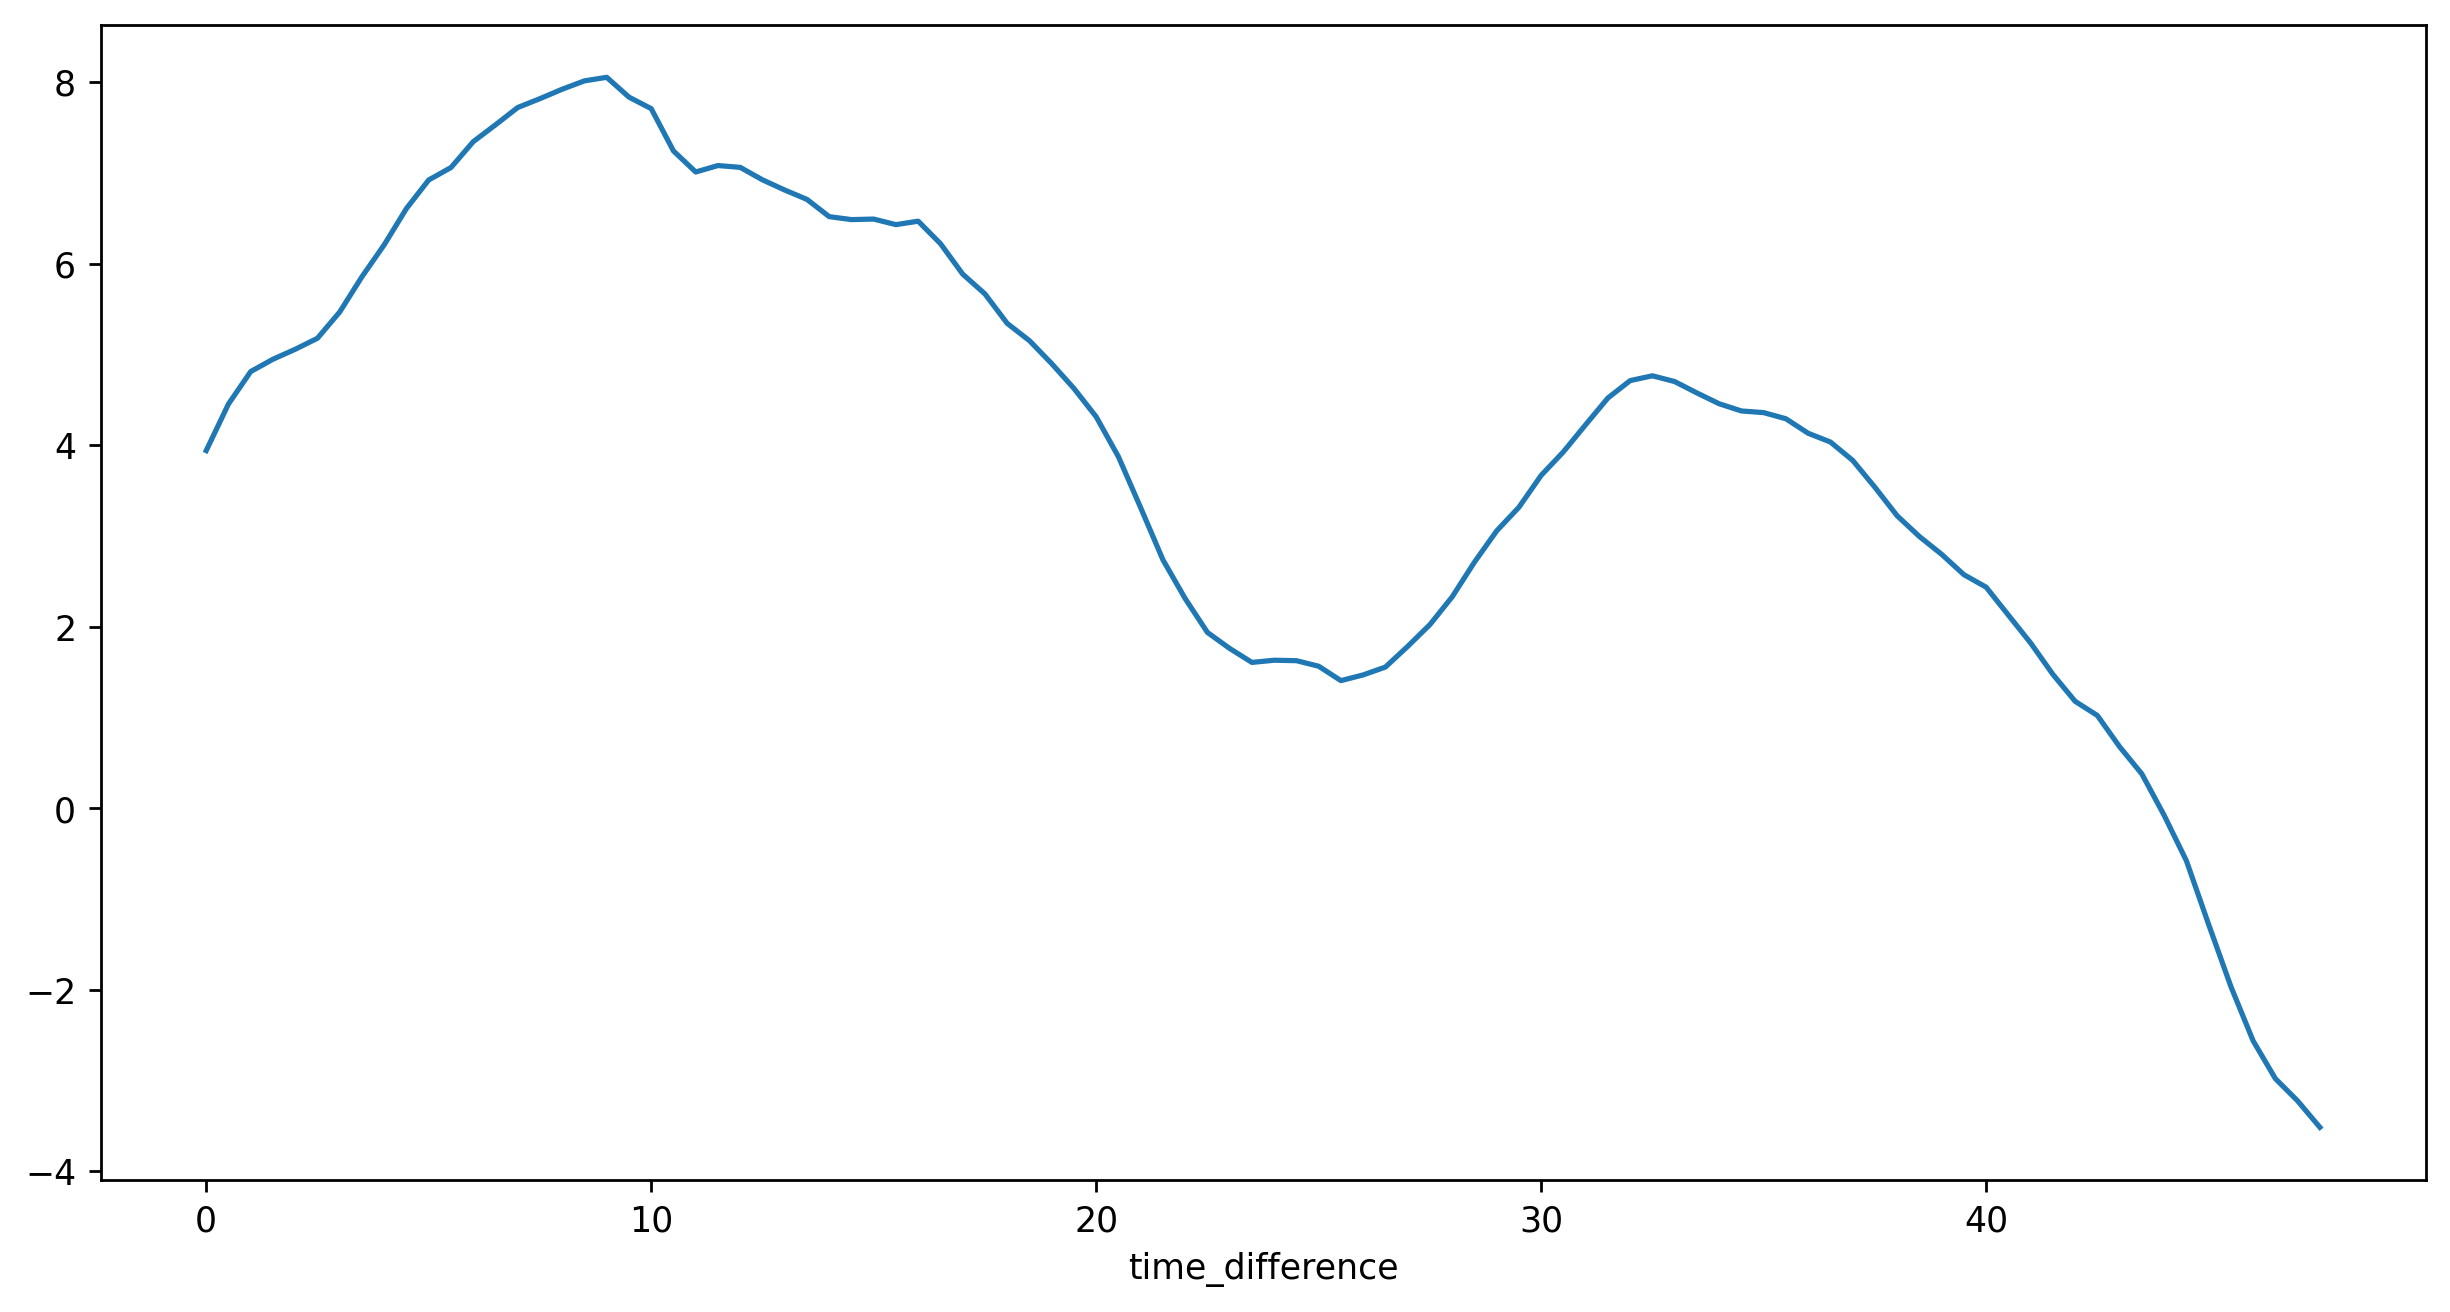

In [191]:
stats.T["mean"].plot()

The forecasts don't improve much closer to the time. In fact they seem to get a little worse, with the limited data I have. The CIs don't seem to change much based on the data I have so far. The standard deviation improves (there's less variability in the amount of error) as the forecasted time approache.

The National Grid model is presumably updated over time to give every forecast, so it would be fairer to use all the data in aggregate rather than per-hour.

In [192]:
dfferr

time_difference,47.5,47.0,46.5,46.0,45.5,45.0,44.5,44.0,43.5,43.0,...,4.5,4.0,3.5,3.0,2.5,2.0,1.5,1.0,0.5,0.0
2023-03-13 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-13 03:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-13 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-13 04:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-13 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-01 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01 11:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-01 12:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
melted_df = pd.melt(dfferr)
flat = melted_df.set_index("time_difference")
flat.agg(["count", "mean", "std", "sem", confidence_95, confidence_99], axis=0)

,value
count,53670
mean,4.10904
std,29.981957
sem,0.129418
confidence_95,"(3.8553802746979104, 4.362700362958055)"
confidence_99,"(3.775670174124932, 4.442410463531034)"


In the above, for any given forecast, there's a 95% chance that the error on a new forecast will be within the range [3.855, 4.363]. I.e. The error will be very close to 4% for any given new forecast.

array([[<Axes: title={'center': 'value'}>]], dtype=object)

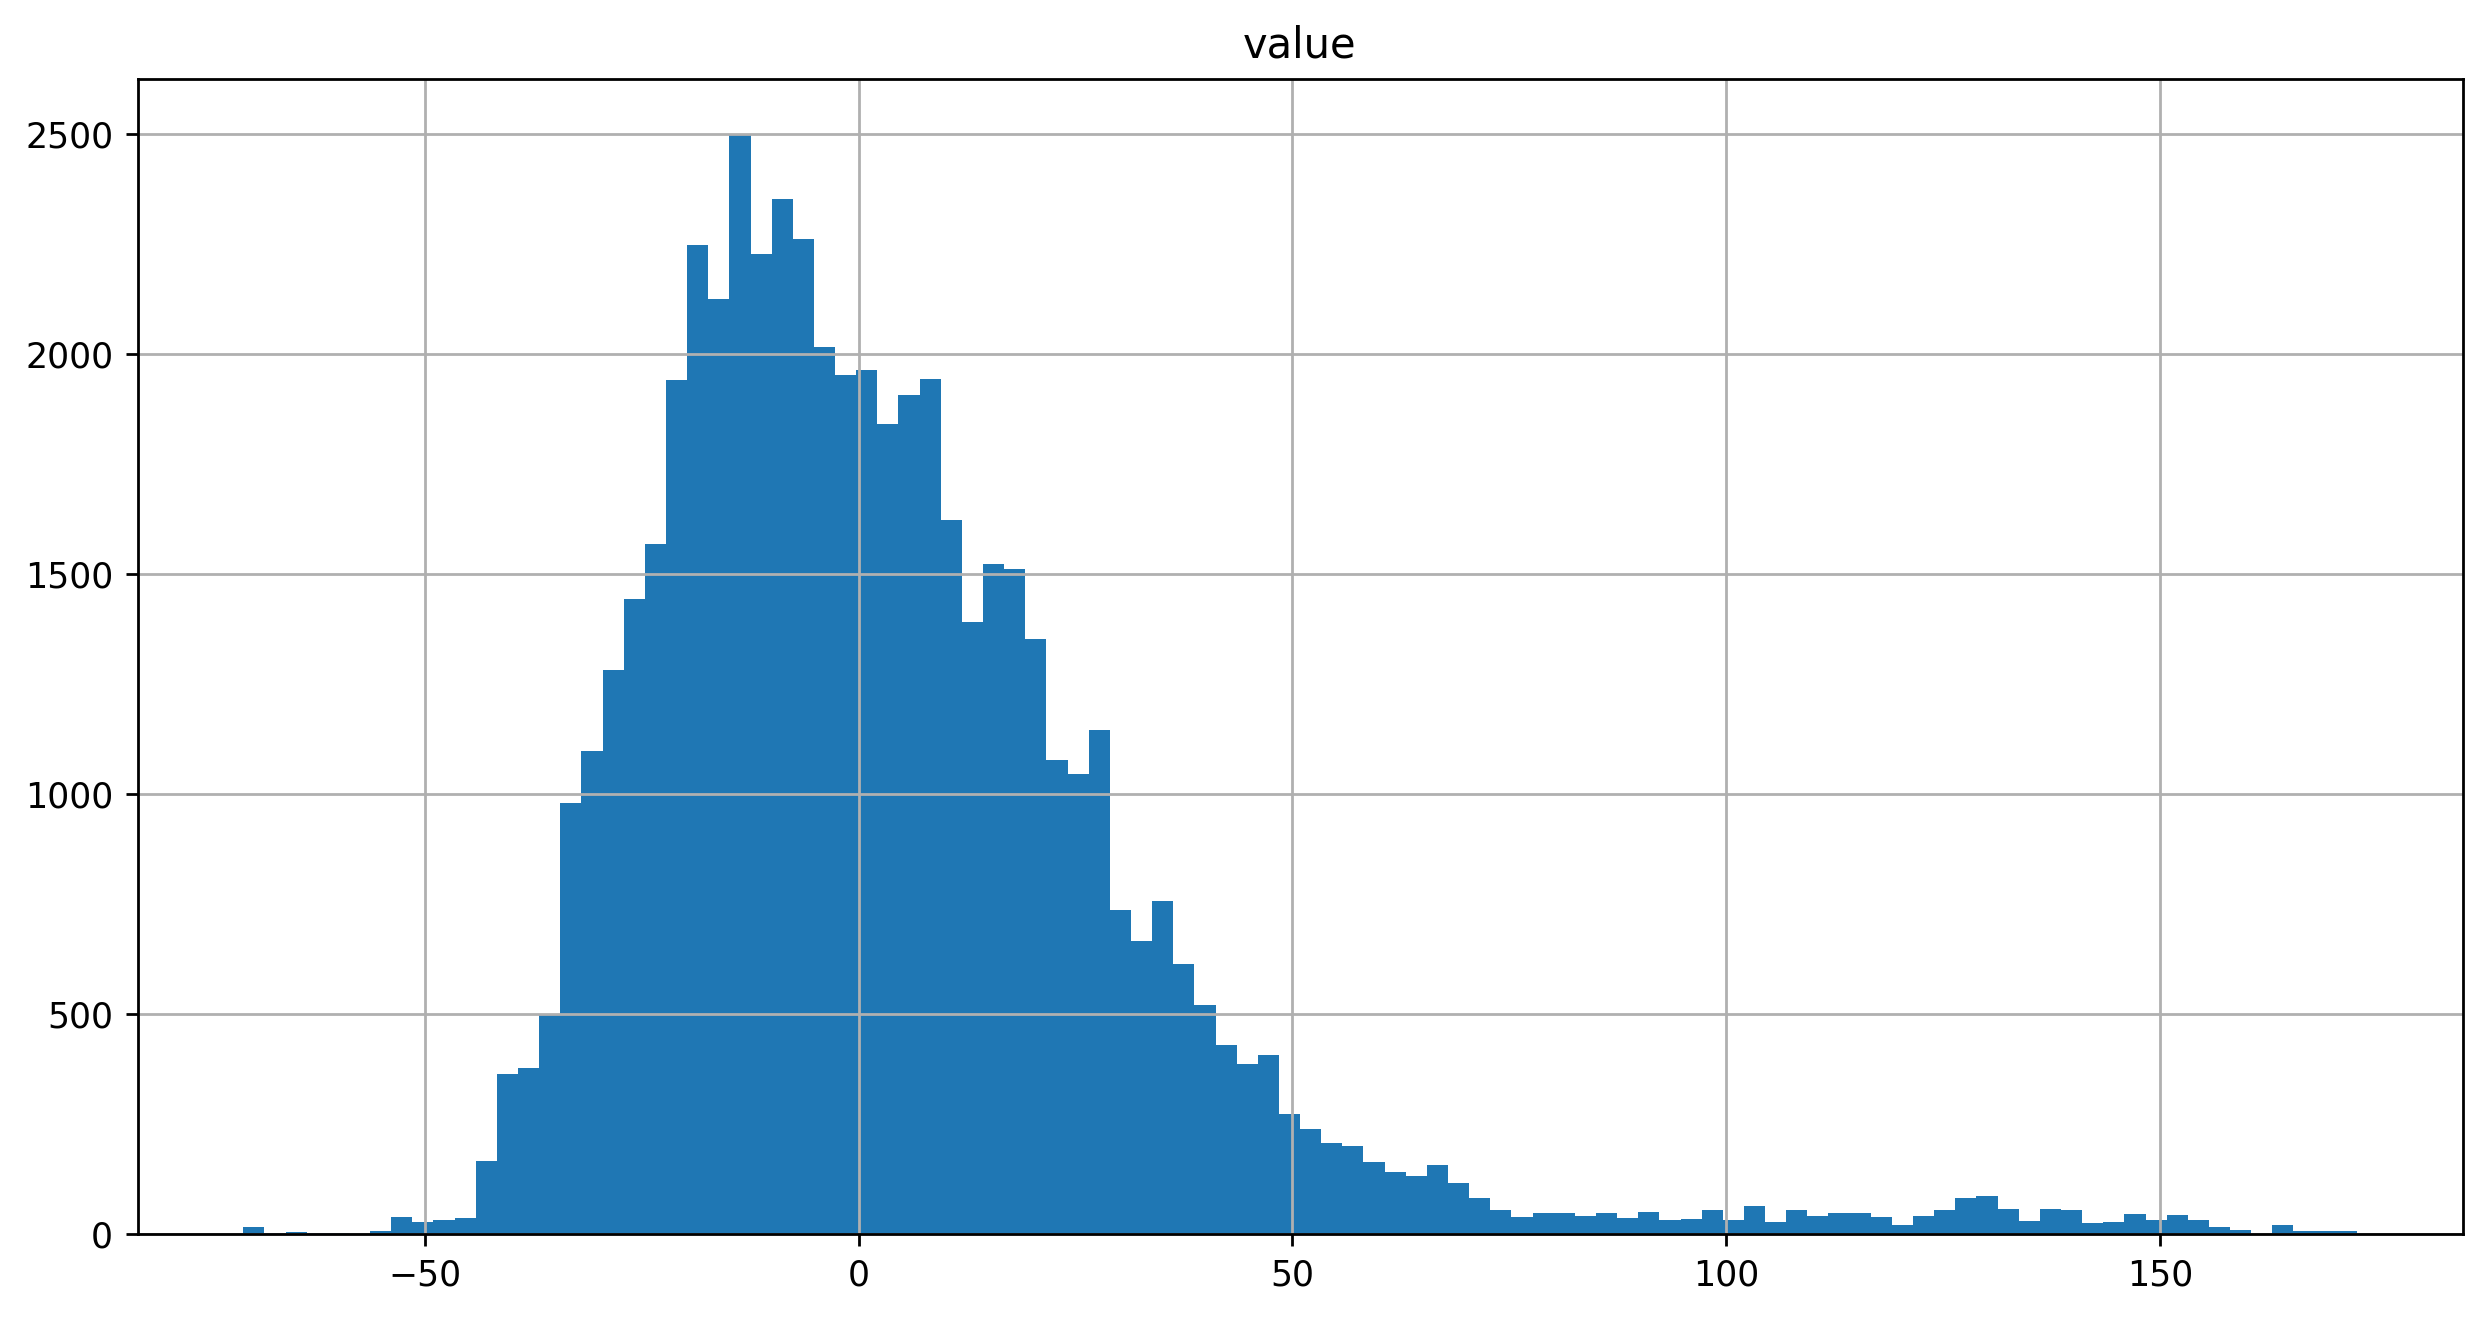

In [194]:
flat.hist(bins=100)

In [195]:
NOW = datetime.now(tz=timezone.utc)
days = 7
merged_df = get_merged_summaries_with_final_actual_intensities("data")

# Get the earliest time from the day a week ago
dt = NOW - timedelta(days=days)
dt = datetime(dt.year, dt.month, dt.day, 0, 0, 0).astimezone(timezone.utc)

# All days from then to now
dff = merged_df.loc[dt:NOW][["intensity.forecast", "intensity.actual.final"]].copy()

# Percentage err
dfferr = 100.0 * (
    dff["intensity.forecast"].sub(dff["intensity.actual.final"], axis=0)
).div(dff["intensity.actual.final"], axis=0)
# only pre-timepoint forecasts
dfferr = dfferr[[c for c in dfferr.columns if float(c) >= 0.0]]

dff = dfferr.copy()
dff.index = dff.index.date

forecast_cols = dff.columns

# Add a helper column to count occurrences of each label
dff["count_per_day"] = dff.groupby(dff.index).cumcount()

# pivot into a multiindex
result = dff.pivot_table(
    index=dff.index,
    columns="count_per_day",
    values=list(forecast_cols),
    aggfunc="first",
)

# flatten
result.columns = [f"{level1}_{level2+1}" for level1, level2 in result.columns]

In [196]:
print(list(result.columns))

['0.0_4', '0.0_5', '0.0_6', '0.0_7', '0.0_8', '0.0_9', '0.0_10', '0.0_11', '0.0_12', '0.0_13', '0.0_14', '0.0_15', '0.0_16', '0.0_17', '0.0_18', '0.0_19', '0.0_20', '0.0_21', '0.0_22', '0.0_23', '0.0_24', '0.0_25', '0.0_26', '0.0_27', '0.0_28', '0.0_29', '0.0_30', '0.0_31', '0.0_32', '0.0_33', '0.0_34', '0.0_35', '0.0_36', '0.0_37', '0.0_38', '0.0_39', '0.0_40', '0.0_41', '0.0_42', '0.0_43', '0.0_44', '0.0_45', '0.0_46', '0.0_47', '0.0_48', '0.5_1', '0.5_5', '0.5_6', '0.5_7', '0.5_8', '0.5_9', '0.5_10', '0.5_11', '0.5_12', '0.5_13', '0.5_14', '0.5_15', '0.5_16', '0.5_17', '0.5_18', '0.5_19', '0.5_20', '0.5_21', '0.5_22', '0.5_23', '0.5_24', '0.5_25', '0.5_26', '0.5_27', '0.5_28', '0.5_29', '0.5_30', '0.5_31', '0.5_32', '0.5_33', '0.5_34', '0.5_35', '0.5_36', '0.5_37', '0.5_38', '0.5_39', '0.5_40', '0.5_41', '0.5_42', '0.5_43', '0.5_44', '0.5_45', '0.5_46', '0.5_47', '0.5_48', '1.0_1', '1.0_2', '1.0_6', '1.0_7', '1.0_8', '1.0_9', '1.0_10', '1.0_11', '1.0_12', '1.0_13', '1.0_14', '1.0_15

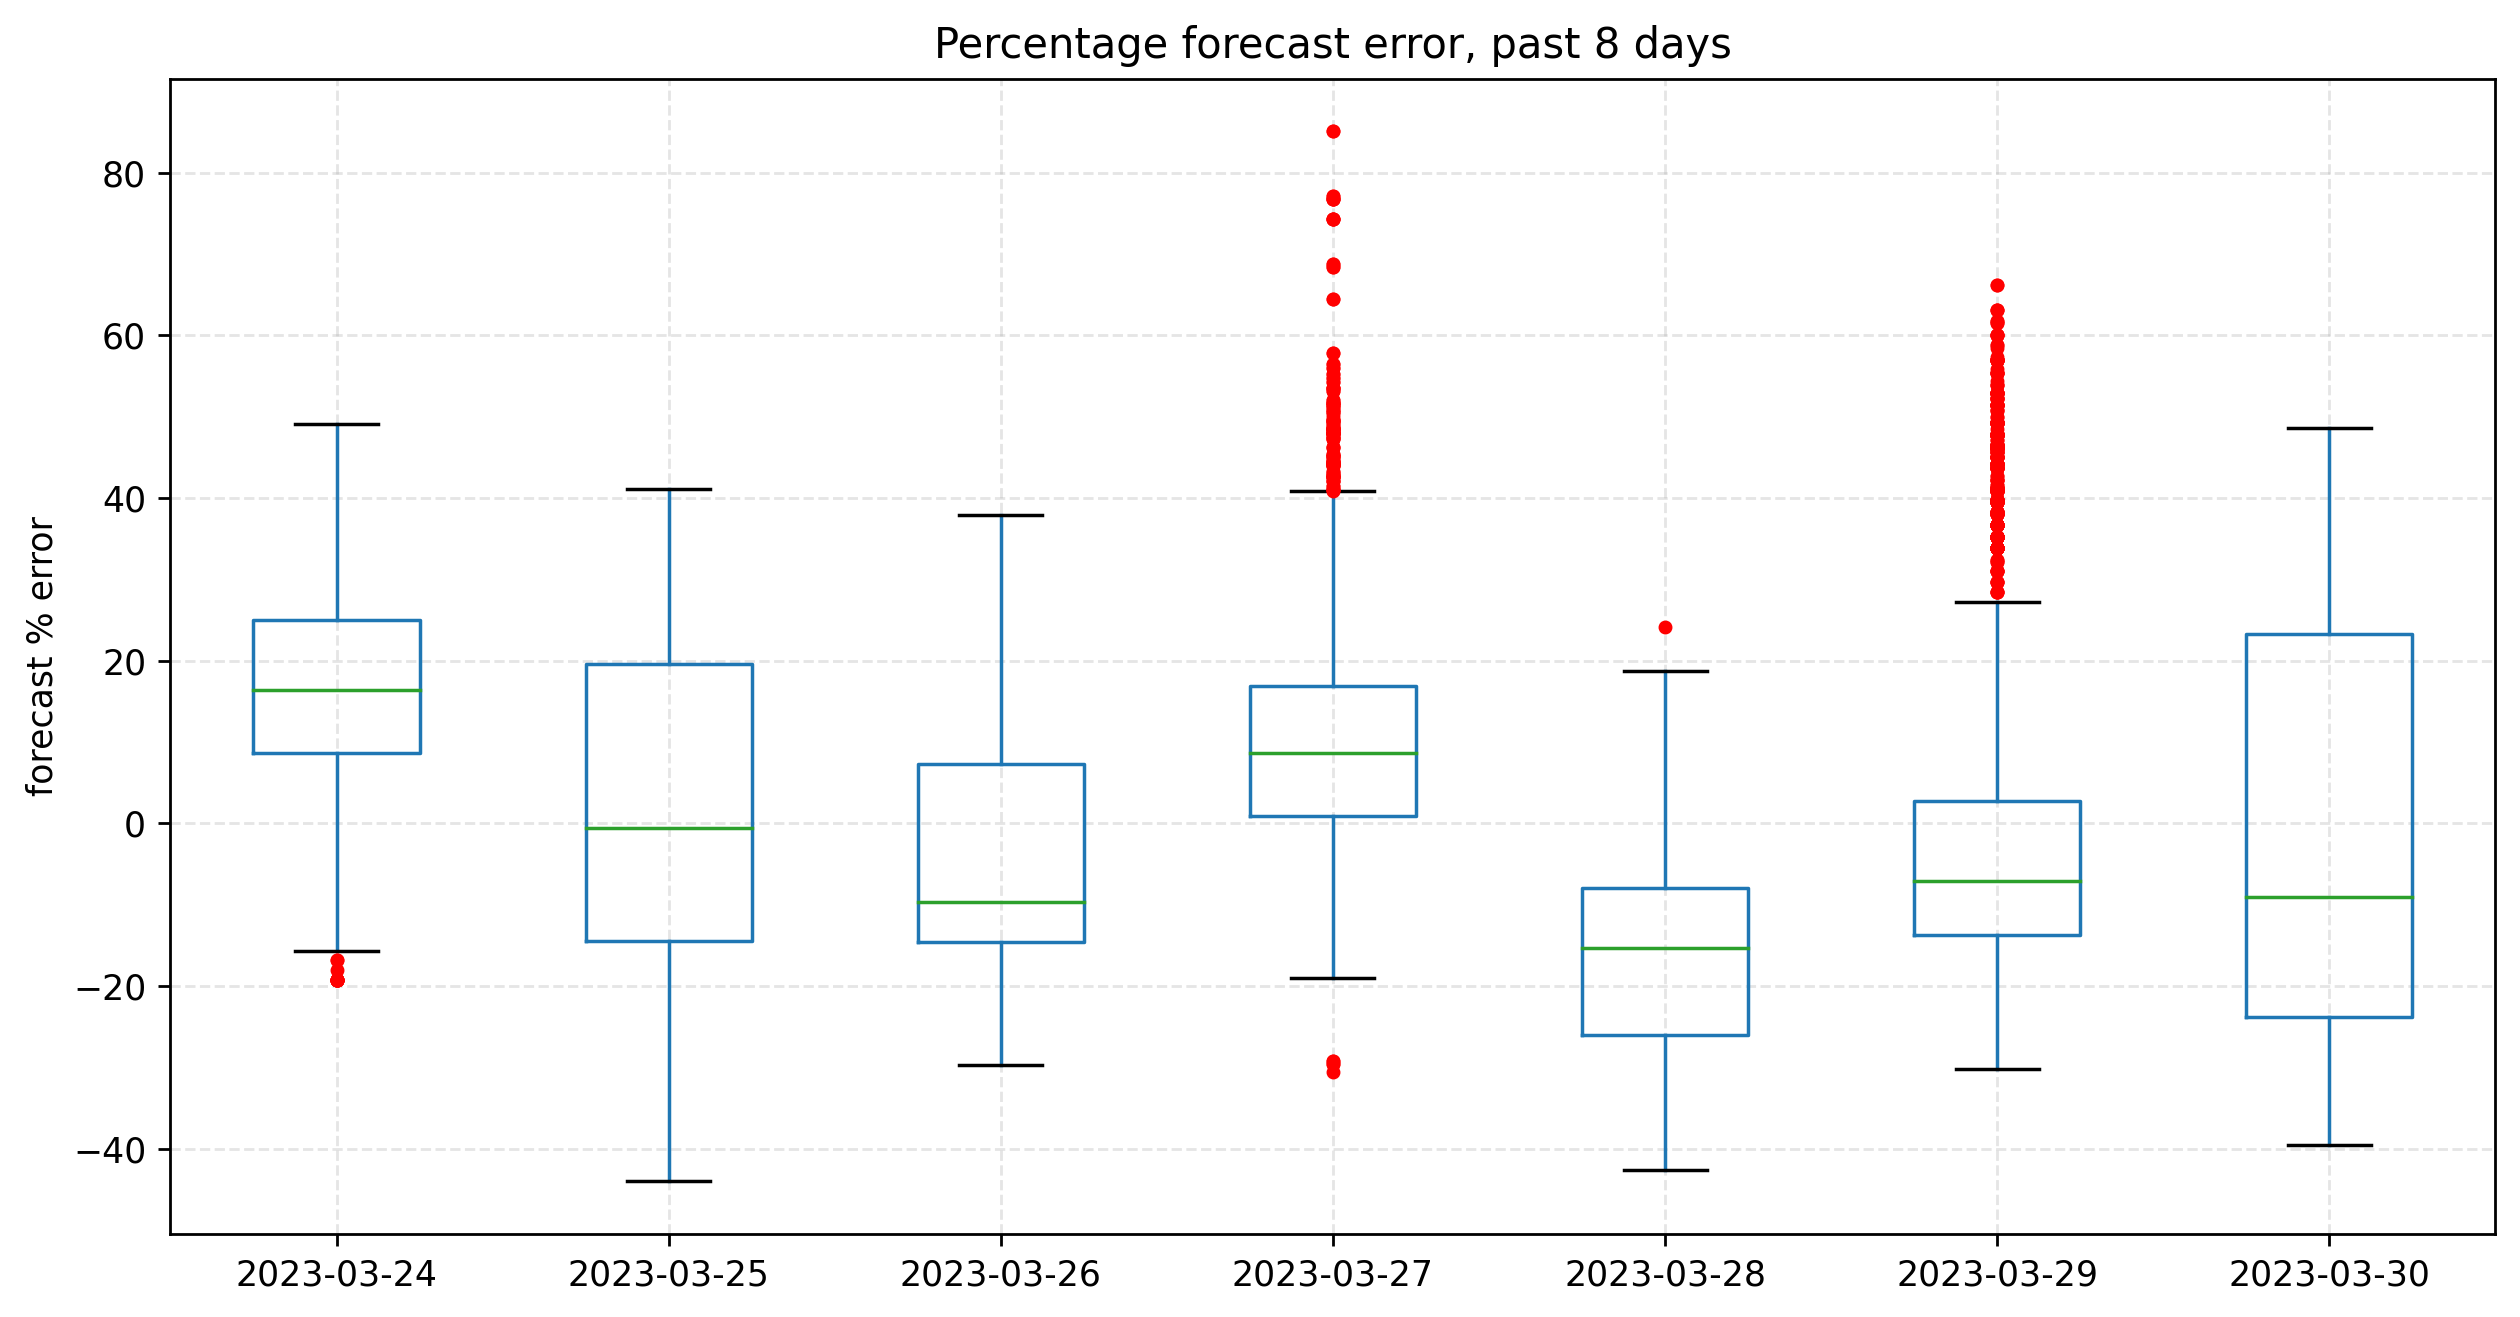

In [197]:
plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

fig, ax = plt.subplots(1, 1)
_ = result.T.boxplot(sym="r.")
ax.set_title(f"Percentage forecast error, past {days+1} days")
ax.set_ylabel("forecast % error")
ax.grid("on", linestyle="--", alpha=0.33)

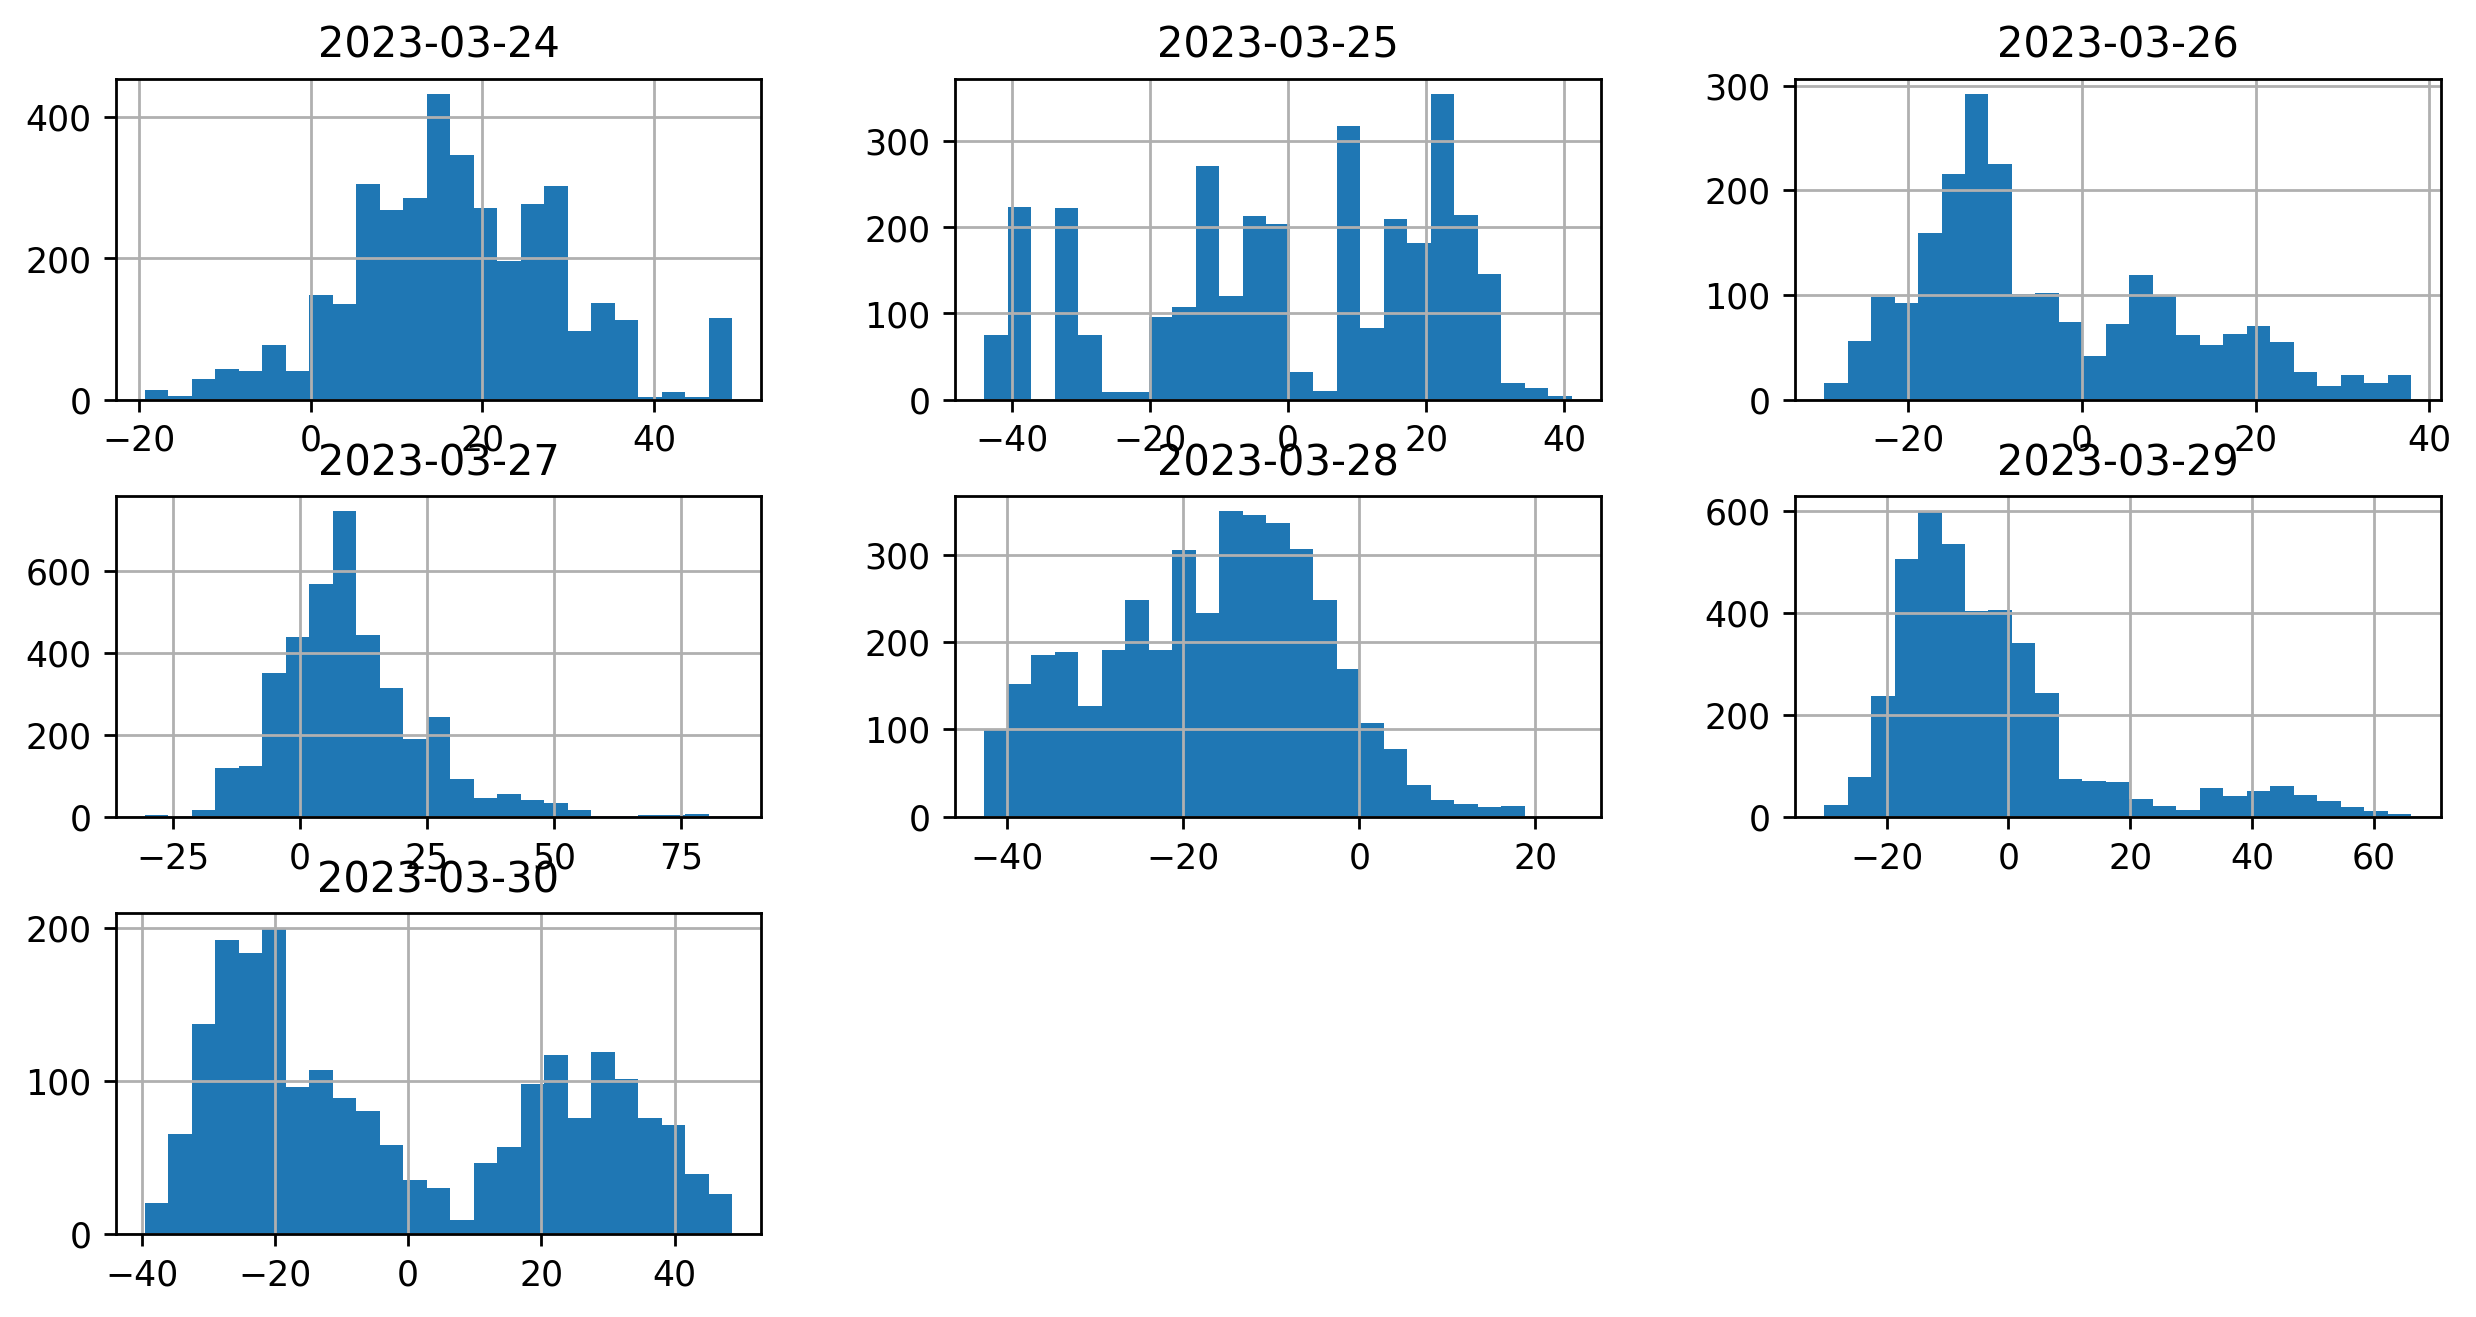

In [198]:
# fig, ax = plt.subplots(1, 1)
ax = result.T.hist(bins=25)

In [199]:
result.T.agg(["count", "mean", "std", "sem", confidence_95, confidence_99], axis=0).T

,count,mean,std,sem,confidence_95,confidence_99
2023-03-24,3696,17.19877,12.361626,0.203334,"(16.800112649015446, 17.597427761051918)","(16.674746299766223, 17.72279411030114)"
2023-03-25,3212,-0.61179,21.85295,0.385587,"(-1.367811722415164, 0.1442312172600766)","(-1.605587089309156, 0.3820065841540685)"
2023-03-26,2167,-3.796125,14.927583,0.320671,"(-4.424980204614443, -3.167269170649705)","(-4.622847596089535, -2.9694017791746137)"
2023-03-27,3859,10.086432,14.055601,0.226262,"(9.642826838716529, 10.530036735847736)","(9.503330485127552, 10.669533089436712)"
2023-03-28,3954,-16.840673,12.437911,0.197801,"(-17.228475368496905, -16.45287110094669)","(-17.350421706993014, -16.330924762450582)"
2023-03-29,3962,-2.577752,17.145098,0.272385,"(-3.1117796112004434, -2.0437247834640173)","(-3.279706976503352, -1.8757974181611088)"
2023-03-30,2128,-0.993004,24.989485,0.541716,"(-2.0553517740724256, 0.06934410498012178)","(-2.3896244461401706, 0.40361677704786625)"


Note these CIs assume an approximate Normal distribution, which we can see from the days' histograms is not true.

In [315]:
48 * 96

4608

In [200]:
from scrape.graph import load_forward_summary
df = load_forward_summary("data")
df

intensity.forecast                                      \
time_difference                000.0 000.5 001.0 001.5 002.0 002.5 003.0   
2023-03-14T03:00Z               68.0   NaN   NaN   NaN   NaN   NaN   NaN   
2023-03-14T03:30Z               69.0  69.0   NaN   NaN   NaN   NaN   NaN   
2023-03-14T04:00Z               76.0  72.0  72.0   NaN   NaN   NaN   NaN   
2023-03-14T04:30Z               77.0  74.0  69.0  69.0   NaN   NaN   NaN   
2023-03-14T05:00Z               77.0  78.0  75.0  72.0  72.0   NaN   NaN   
...                              ...   ...   ...   ...   ...   ...   ...   
2023-04-01T11:00Z                NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01T11:30Z                NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01T12:00Z                NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01T12:30Z                NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2023-04-01T13:00Z                NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                     ... intensity.actual                    \
time_difference   003.5 004.0 004.5  ...            043.0 043.5 044.0 044.5   
2023-03-14T03:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-14T03:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-14T04:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-14T04:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-03-14T05:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
...                 ...   ...   ...  ...              ...   ...   ...   ...   
2023-04-01T11:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-04-01T11:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-04-01T12:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-04-01T12:30Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   
2023-04-01T13:00Z   NaN   NaN   NaN  ...              NaN   NaN   NaN   NaN   

                                                       
time_difference   045.0 045.5 046.0 046.5 047.0 047.5  
2023-03-14T03:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-14T03:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-14T04:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-14T04:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-03-14T05:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
...                 ...   ...   ...   ...   ...   ...  
2023-04-01T11:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-04-01T11:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-04-01T12:00Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-04-01T12:30Z   NaN   NaN   NaN   NaN   NaN   NaN  
2023-04-01T13:00Z   NaN   NaN   NaN   NaN   NaN   NaN  

[885 rows x 192 columns]

IndexError: list index out of range

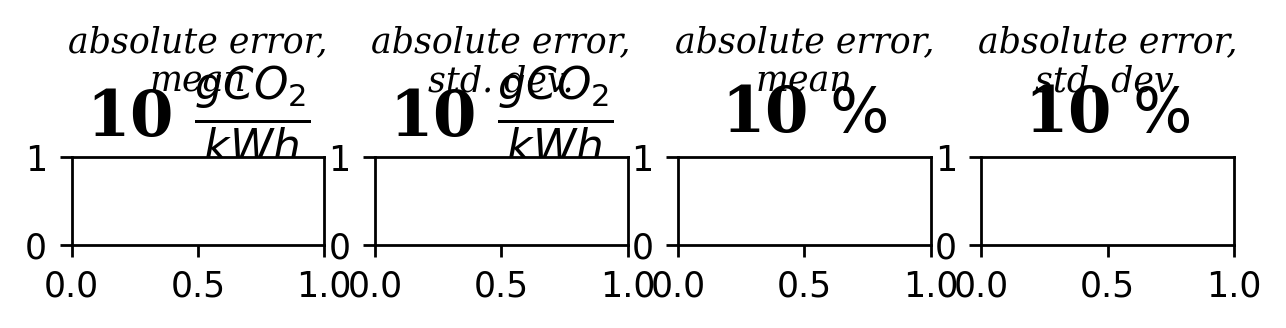

In [95]:
plt.rcParams["figure.figsize"] = [6, 1]
plt.rcParams["figure.dpi"] = 250

fig, axs = plt.subplots(nrows=2, ncols=4, squeeze=0)
font_a = {
        "family": "serif",
        "style": "normal",
        "color":  "black",
        "weight": "bold",
        "size": 18,
        }
font_b = {
        "family": "serif",
        "style": "italic",
        "color":  "black",
        "weight": "normal",
        "size": 10,
        }

titles = ["absolute error,\nmean", "absolute error,\nstd. dev.", "absolute error,\nmean", "absolute error,\nstd. dev."]
units = [r"$\frac{gCO_{2}}{kWh}$", r"$\frac{gCO_{2}}{kWh}$", r"$\%$", r"$\%$"]
values = [10, 10, 10, 10]

for ix, ax in enumerate(axs.reshape(-1)):
    ax.text(0.5, 0.9, titles[ix], fontdict=font_b,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes)
    ax.text(0.5, 0.3, str(values[ix]) + " " + units[ix], fontdict=font_a,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes)
    ax.axis("off")

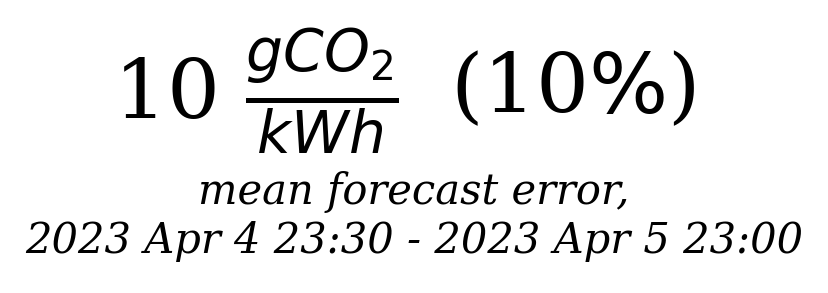

In [313]:
plt.rcParams["figure.figsize"] = [3,1.2]
plt.rcParams["figure.dpi"] = 250

ci_mean = int(10.0)

# fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=0)
font_a = {
        "family": "serif",
        "style": "normal",
        "color":  "black",
        "weight": "normal",
        "size": 24,
        }
font_b = font_a | {
        "style": "italic",
        "size": 12,
        }
font_c = {
        "family": "serif",
        "style": "italic",
        "color":  "black",
        "weight": "normal",
        "size": 12,
        }

fig = plt.figure()
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.text(0.5, 0.5, f"{ci_mean} " + r"$\frac{gCO_{2}}{kWh}$", fontdict=font_a, horizontalalignment="center", verticalalignment="center", transform=ax1.transAxes)
ax2.text(0.5, 0.5, f"({ci_mean}" + r"$\%$" + f")", fontdict=font_a, horizontalalignment="center", verticalalignment="center", transform=ax2.transAxes)

ax3.text(0.5, 0.5, "mean forecast error,\n2023 Apr 4 23:30 - 2023 Apr 5 23:00", fontdict=font_c,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax3.transAxes)

for ax in (ax1, ax2, ax3):
    ax.axis("off")

# # titles = ["absolute error,\nmean", "absolute error,\nstd. dev.", "absolute error,\nmean", "absolute error,\nstd. dev."]
# units = [r"$\frac{gCO_{2}}{kWh}$", r"$(\%)$"]
# values = [10, 10]

# for ix, ax in enumerate(axs.reshape(-1)):
    
#     ax.text(0.5, 0.3, captions[ix], fontdict=font_b,
#         horizontalalignment="center",
#         verticalalignment="center",
#         transform=ax.transAxes)
#     ax.axis("off")

In [ ]:
# Credit to Dr. Michael Demastrie, at https://towardsdatascience.com/simple-little-tables-with-matplotlib-9780ef5d0bc4

DPI = 250
plt.rcParams["figure.figsize"] = [6, 2]
plt.rcParams["figure.dpi"] = 250

title_text = "absolute error"
daterange = f"2023 Apr 4 00:30 - 2023 Apr 5 00:00"
# fig_background_color = "skyblue"
# fig_border = "steelblue"
data =  [
            [ "mean", "standard deviation"],
            [ r"$gCO_{2} / kWh$",  66386, 174296],
            [r"$\%$",  58230, 381139],
        ]# Pop the headers from the data array
column_headers = data.pop(0)
row_headers = [x.pop(0) for x in data]# Table data needs to be non-numeric text. Format the data
# while I"m at it.
cell_text = []
for row in data:
    cell_text.append([f"{x/1000:1.1f}" for x in row])

# Get some lists of color specs for row and column headers
rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

# Create the figure. Setting a small pad on tight_layout
# seems to better regulate white space. Sometimes experimenting
# with an explicit figsize here can produce better outcome.
plt.figure(linewidth=0,
#            edgecolor=fig_border,
#            facecolor=fig_background_color,
           tight_layout={"pad":1},
          )

# Add a table at the bottom of the axes
table = plt.table(cellText=cell_text,
                      rowLabels=row_headers,
                      rowColours=rcolors,
                      rowLoc="right",
                      colColours=ccolors,
                      colLabels=column_headers,
                      loc="center")# Scaling is the only influence we have over top and bottom cell padding.

# Make the rows taller (i.e., make cell y scale larger).
table.scale(1, 2.0)
# Hide axes
ax = plt.gca()
# Hide axes border
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title(title_text + daterange)
# plt.suptitle(title_text + daterange, size=14)

# Add footer
# Force the figure to update, so backends center objects correctly within the figure.
# plt.figtext(0.95, 0.05, footer_date, horizontalalignment="center", size=12, weight="normal")
# Without plt.draw() here, the title will center on the axes and not the figure.
plt.draw()  # Create image. plt.savefig ignores figure edge and face colors, so map them.

# fig = plt.gcf()
# plt.savefig("pyplot-table-demo.png",
#             #bbox="tight",
#             edgecolor=fig.get_edgecolor(),
#             facecolor=fig.get_facecolor(),
#             dpi=DPI
#             )

Text(0.0, 1.0, 'Forecast error')

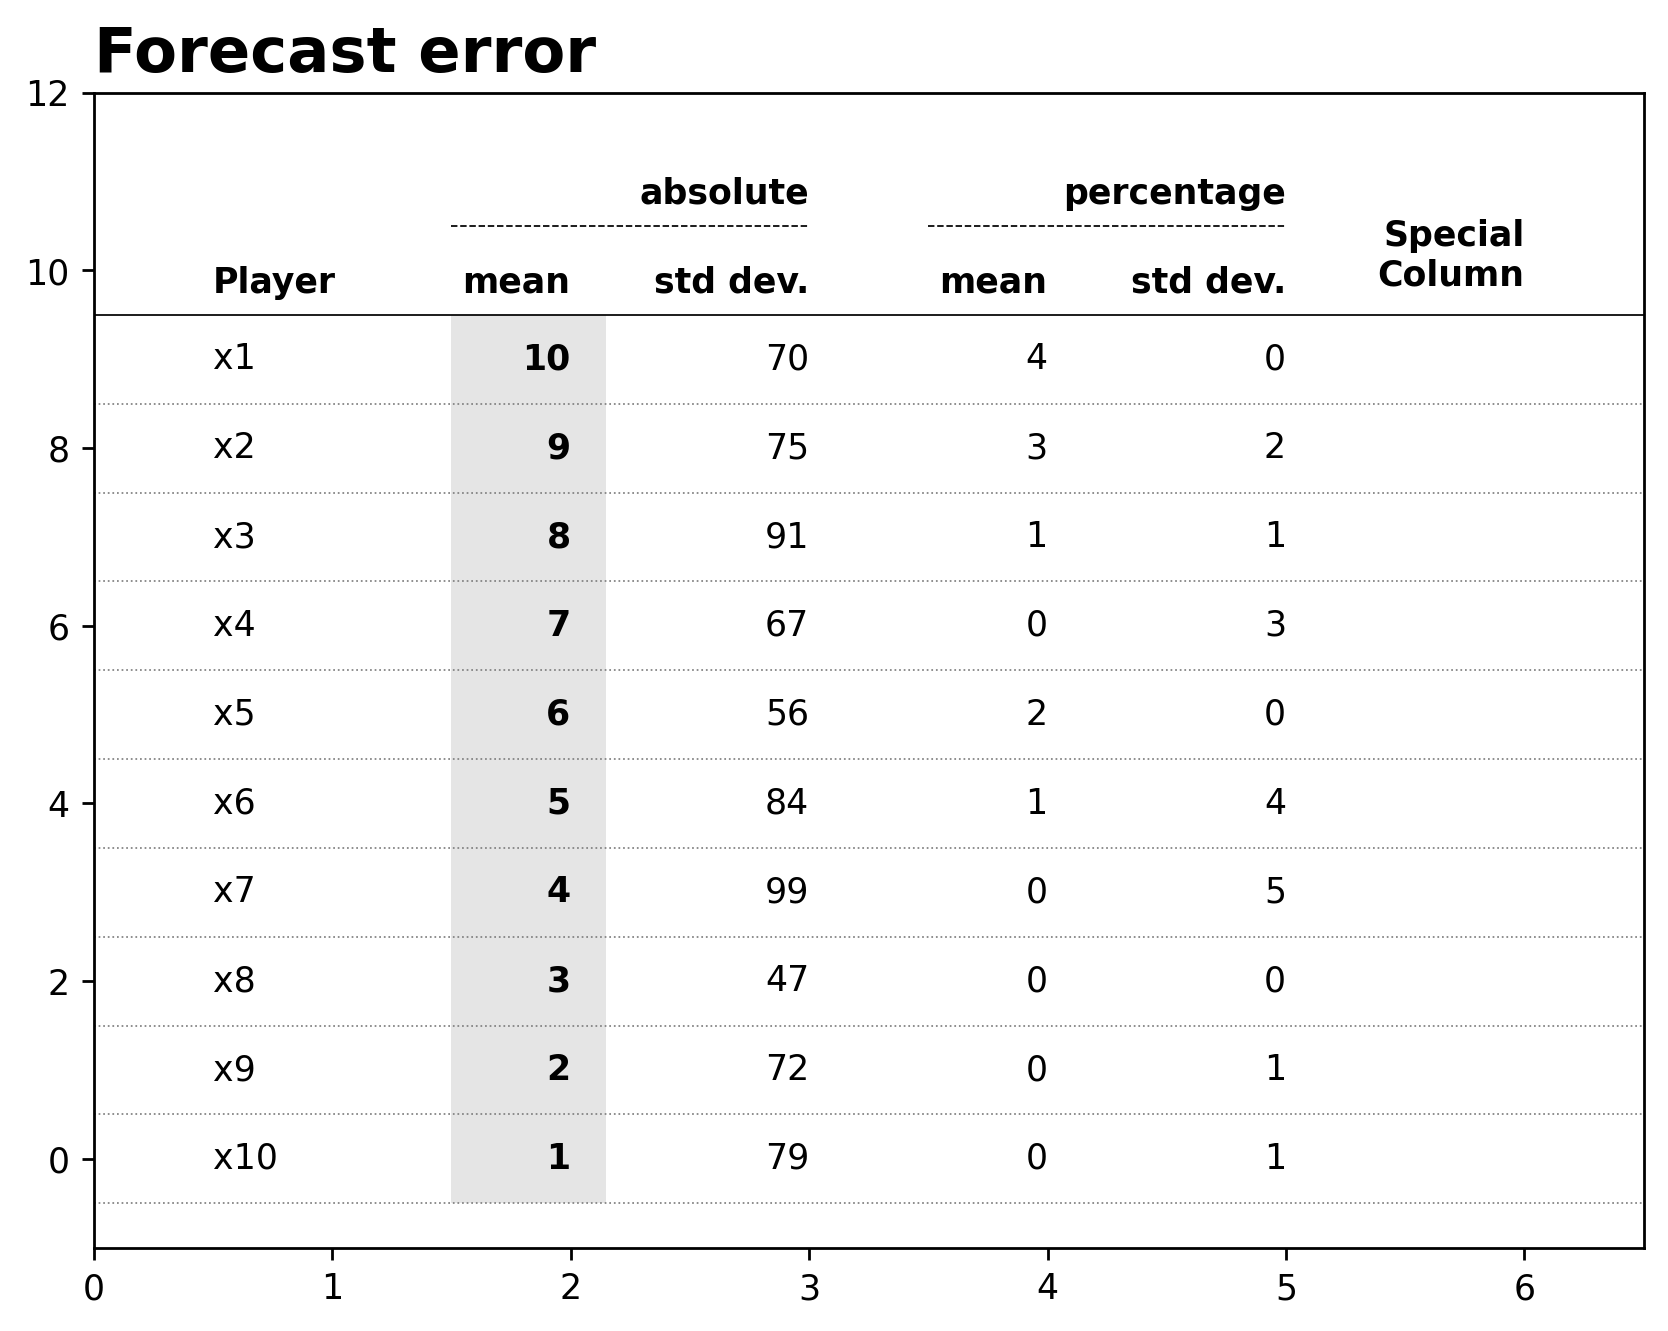

In [238]:
# Credit: https://matplotlib.org/matplotblog/posts/how-to-create-custom-tables/

import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt

# first, we"ll create a new figure and axis object

fig, ax = plt.subplots(figsize=(8,6))

# set the number of rows and cols for our table
rows = 10
cols = 6

# create a coordinate system based on the number of rows/columns
# adding a bit of padding on bottom (-1), top (1), right (0.5)

ax.set_ylim(-1, rows + 2)
ax.set_xlim(0, cols + .5)

# sample data

data = [
        {"id": "x10", "shots": 1, "passes": 79, "goals": 0, "assists": 1},
        {"id": "x9", "shots": 2, "passes": 72, "goals": 0, "assists": 1},
        {"id": "x8", "shots": 3, "passes": 47, "goals": 0, "assists": 0},
        {"id": "x7", "shots": 4, "passes": 99, "goals": 0, "assists": 5},
        {"id": "x6", "shots": 5, "passes": 84, "goals": 1, "assists": 4},
        {"id": "x5", "shots": 6, "passes": 56, "goals": 2, "assists": 0},
        {"id": "x4", "shots": 7, "passes": 67, "goals": 0, "assists": 3},
        {"id": "x3", "shots": 8, "passes": 91, "goals": 1, "assists": 1},
        {"id": "x2", "shots": 9, "passes": 75, "goals": 3, "assists": 2},
        {"id": "x1", "shots": 10, "passes": 70, "goals": 4, "assists": 0}
]

# from the sample data, each dict in the list represents one row

# each key in the dict represents a column

for row in range(rows):
    # extract the row data from the list

    d = data[row]

    # the y (row) coordinate is based on the row index (loop)

    # the x (column) coordinate is defined based on the order I want to display the data in


    # player name column

    ax.text(x=.5, y=row, s=d["id"], va="center", ha="left")
    # shots column - this is my "main" column, hence bold text

    ax.text(x=2, y=row, s=d["shots"], va="center", ha="right", weight="bold")
    # passes column

    ax.text(x=3, y=row, s=d["passes"], va="center", ha="right")
    # goals column

    ax.text(x=4, y=row, s=d["goals"], va="center", ha="right")
    # assists column

    ax.text(x=5, y=row, s=d["assists"], va="center", ha="right")

    # Add column headers

    # plot them at height y=9.75 to decrease the space to the

    # first data row (you"ll see why later)

ax.text(3, rows + 0.75, "absolute", weight="bold", ha="right")
ax.text(5, rows + 0.75, "percentage", weight="bold", ha="right")
ax.text(.5, rows - 0.25, "Player", weight="bold", ha="left")
ax.text(2, rows - 0.25, "mean", weight="bold", ha="right")
ax.text(3, rows - 0.25, "std dev.", weight="bold", ha="right")
ax.text(4, rows - 0.25, "mean", weight="bold", ha="right")
ax.text(5, rows - 0.25, "std dev.", weight="bold", ha="right")
ax.text(6, rows - 0.25, "Special\nColumn", weight="bold", ha="right", va="bottom")

#     Adding Headers

ax.plot(
    [1.5, 3.0],
    [rows + 1 -.5, rows + 1 - .5],
    ls="--",
    lw=".5",
    c="black"
)
ax.plot(
    [3.5, 5.0],
    [rows + 1 -.5, rows + 1 - .5],
    ls="--",
    lw=".5",
    c="black"
)

for row in range(rows):
    ax.plot(
        [0, cols + 1],
        [row -.5, row - .5],
        ls=":",
        lw=".5",
        c="grey"
    )

# add a main header divider
# remember that we plotted the header row slightly closer to the first data row
# this helps to visually separate the header row from the data rows
# each data row is 1 unit in height, thus bringing the header closer to our 
# gridline gives it a distinctive difference.

ax.plot([0, cols + 1], [9.5, 9.5], lw=".5", c="black")

# highlight the column we are sorting by

# using a rectangle patch

rect = patches.Rectangle(
    (1.5, -.5),  # bottom left starting position (x,y)
    .65,  # width
    rows,   # height
    ec="none",
    fc="grey",
    alpha=.2,
    zorder=-1
)
ax.add_patch(rect)

# ax.axis("off")

ax.set_title(
    "Forecast error",
    loc="left",
    fontsize=18,
    weight="bold"
)

Text(0.0, 1.0, 'Forecast error')

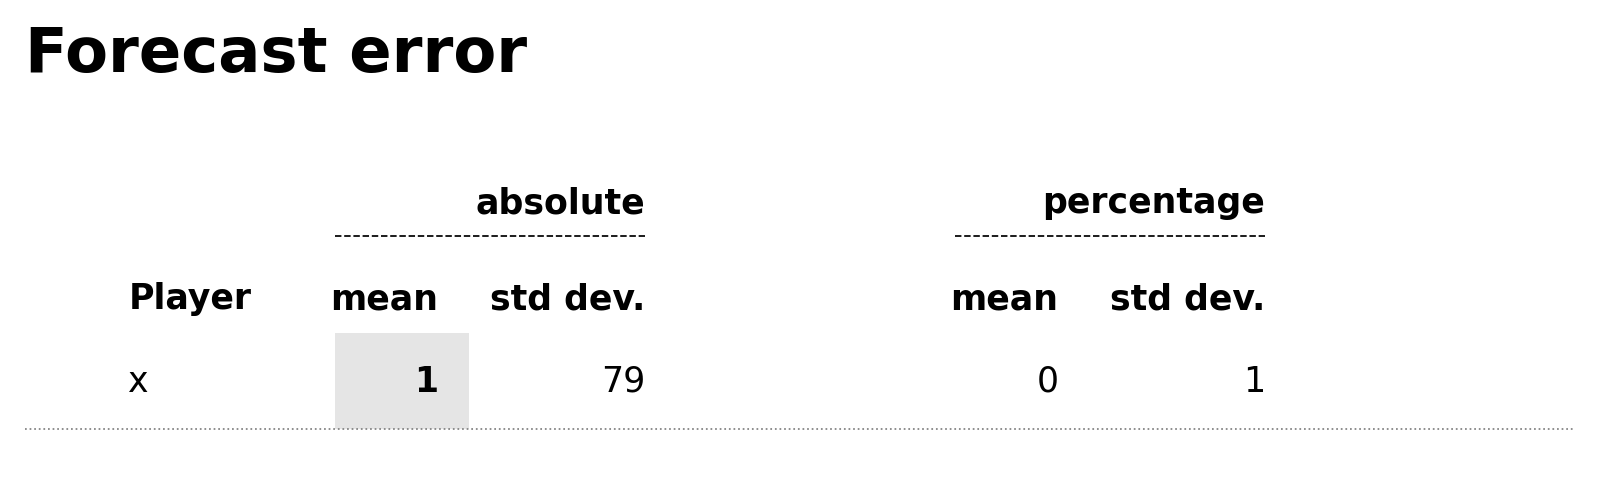

In [239]:
# Credit: https://matplotlib.org/matplotblog/posts/how-to-create-custom-tables/

import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib import pyplot as plt

# first, we"ll create a new figure and axis object

fig, ax = plt.subplots(figsize=(8,2))

# set the number of rows and cols for our table
rows = 1
cols = 7

# create a coordinate system based on the number of rows/columns
# adding a bit of padding on bottom (-1), top (1), right (0.5)

ax.set_ylim(-1, rows + 2)
ax.set_xlim(0, cols + .5)

# sample data

data = [
        {"id": "x", "shots": 1, "passes": 79, "goals": 0, "assists": 1},
]

# from the sample data, each dict in the list represents one row

# each key in the dict represents a column

for row in range(rows):
    # extract the row data from the list

    d = data[row]

    # the y (row) coordinate is based on the row index (loop)

    # the x (column) coordinate is defined based on the order I want to display the data in


    # player name column

    ax.text(x=.5, y=row, s=d["id"], va="center", ha="left")
    # shots column - this is my "main" column, hence bold text

    ax.text(x=2, y=row, s=d["shots"], va="center", ha="right", weight="bold")
    # passes column

    ax.text(x=3, y=row, s=d["passes"], va="center", ha="right")
    # goals column

    ax.text(x=5, y=row, s=d["goals"], va="center", ha="right")
    # assists column

    ax.text(x=6, y=row, s=d["assists"], va="center", ha="right")

# Add column headers
# plot them at height y=9.75 to decrease the space to the
# first data row (you"ll see why later)

ax.text(3, rows + 0.75, "absolute", weight="bold", ha="right")
ax.text(6, rows + 0.75, "percentage", weight="bold", ha="right")
ax.text(.5, rows - 0.25, "Player", weight="bold", ha="left")
ax.text(2, rows - 0.25, "mean", weight="bold", ha="right")
ax.text(3, rows - 0.25, "std dev.", weight="bold", ha="right")
ax.text(5, rows - 0.25, "mean", weight="bold", ha="right")
ax.text(6, rows - 0.25, "std dev.", weight="bold", ha="right")
# ax.text(6, rows - 0.25, "Special\nColumn", weight="bold", ha="right", va="bottom")

#     Adding Headers

# Group headers cover multiple columns
group_1_cols = 2
group_1_col_start = 1.5
group_1_col_end = group_1_col_start // 1 + group_1_cols

ax.plot(
    [group_1_col_start, group_1_col_end],
    [rows + 1 -.5, rows + 1 - .5],
    ls="--",
    lw=".5",
    c="black"
)

group_2_cols = 2
group_2_col_start = 4.5
group_2_col_end = group_2_col_start // 1 + group_2_cols

ax.plot(
    [group_2_col_start, group_2_col_end],
    [rows + 1 -.5, rows + 1 - .5],
    ls="--",
    lw=".5",
    c="black"
)

for row in range(rows):
    ax.plot(
        [0, cols + 1],
        [row -.5, row - .5],
        ls=":",
        lw=".5",
        c="grey"
    )

# add a main header divider
# remember that we plotted the header row slightly closer to the first data row
# this helps to visually separate the header row from the data rows
# each data row is 1 unit in height, thus bringing the header closer to our 
# gridline gives it a distinctive difference.

ax.plot([0, cols + 1], [9.5, 9.5], lw=".5", c="black")

# highlight the column we are sorting by

# using a rectangle patch

rect = patches.Rectangle(
    (1.5, -.5),  # bottom left starting position (x,y)
    .65,  # width
    rows,   # height
    ec="none",
    fc="grey",
    alpha=.2,
    zorder=-1
)
ax.add_patch(rect)

ax.axis("off")

ax.set_title(
    "Forecast error",
    loc="left",
    fontsize=18,
    weight="bold"
)


NameError: name 'df' is not defined